# Phase curves

Inspired by https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP03_04a_Introduction_to_Phase_Curves.ipynb

In [2]:
from db import query
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from scipy.interpolate import CubicSpline
import seaborn as sns 

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}

In [3]:
def semi_major_axis(q, e):
    '''
    Calculate the semi-major axis, a.
    '''
    return q/(1 - e)

def reduced_magnitude(m, hd, td):
    return m - 5.0*np.log10(hd*td)

In [4]:
alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2,
            3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2,
            1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1,
            1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]

phi_1 = CubicSpline(alpha_12, phi_1_sp,
                    bc_type=((1, phi_1_derivs[0]), (1, phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp,
                    bc_type=((1, phi_2_derivs[0]), (1, phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp,
                    bc_type=((1, phi_3_derivs[0]), (1, phi_3_derivs[1])))

def HG1G2_model(phase, params):
    """
    Compute HG1G2 model phase curve for a given set
    of parameters. This is a 3-parameter model, which works best
    when sufficiently long phaseangle coverage is available.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters [H, G1, G2]

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    phi_1_ev = phi_1(phase)
    phi_2_ev = phi_2(phase)
    phi_3_ev = phi_3(phase)

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6 * phase[msk]/np.pi
    phi_2_ev[msk] = 1-9 * phase[msk]/(5 * np.pi)

    phi_3_ev[phase > np.pi/6] = 0

    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev
                                      + params[2] * phi_2_ev
                                      + (1-params[1]-params[2]) * phi_3_ev)

def HG12_model(phase, params):
    """
    Compute HG12 model phase curve for a given set
    of parameters. This is a 2-parameter, simplified version
    of HG1G2 model, which is useful when phaseangle coverage is shorter.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters [H, G12]

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

In [5]:
N_obs = 1000

stmt = """
SELECT
    mpc.ssObjectId, mpc.e, mpc.q, mpc.mpcG, mpc.mpcH,
    sso.arc, sso.numObs,
    sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err,
    sso.g_H_gG12_Cov, sso.g_Ndata, sso.r_H, sso.r_Herr,
    sso.r_G12, sso.r_G12err, sso.r_H_rG12_Cov, sso.r_Ndata,
    sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err, sso.i_H_iG12_Cov,
    sso.i_Ndata, sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err,
    sso.z_H_zG12_Cov, sso.z_Ndata
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE sso.numObs >= {} ORDER by sso.ssObjectId
""".format(str(N_obs))

uniqueObj = query(stmt).to_table()
uniqueObj

ssObjectId,e,q,mpcG,mpcH,arc,numObs,g_H,g_Herr,g_G12,g_G12err,g_H_gG12_Cov,g_Ndata,r_H,r_Herr,r_G12,r_G12err,r_H_rG12_Cov,r_Ndata,i_H,i_Herr,i_G12,i_G12err,i_H_iG12_Cov,i_Ndata,z_H,z_Herr,z_G12,z_G12err,z_H_zG12_Cov,z_Ndata
,,AU,,mag,d,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,
int64,float64,float64,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32
-9217466392671047318,0.14236387557684574,2.361473543230547,0.15,14.48,3099.2915,2866,15.203103,0.00038897144,0.4550666,0.0040478734,7.9422597e-07,461,14.554703,0.00021039916,0.48015854,0.0020262992,1.7115104e-07,958,14.354623,0.00025000537,0.4709413,0.0025779733,2.3757198e-07,974,14.407989,0.0006071515,0.51356506,0.005866336,1.1365114e-06,473
-9212449919165436923,0.1783349289362343,45.60417410237429,0.15,6.55,3297.8752,1058,--,--,--,--,--,0,--,--,--,--,--,0,--,--,--,--,--,0,--,--,--,--,--,0
-9211286014772213856,0.0658162997382177,2.889876412979229,0.15,16.54,3615.123,1766,17.275288,0.00289577,0.61713177,0.01509817,3.64732e-05,260,16.621004,0.0016441342,0.5858086,0.008620237,1.1435597e-05,537,16.41983,0.0020172396,0.5698511,0.010459836,1.702569e-05,562,16.475334,0.004990022,0.5678376,0.024085298,0.000110812514,407
-9208533592888360514,0.06660949805582513,2.9573803920849002,0.15,14.64,3169.8425,1055,15.380815,0.0022028869,0.6222429,0.011123902,2.345728e-05,132,14.729256,0.0012424011,0.6160314,0.0063005416,7.4654936e-06,288,14.525853,0.0013949565,0.59334964,0.007084308,9.326134e-06,287,14.582087,0.0024085627,0.6059947,0.012006525,2.7753556e-05,348
-9198319934054407073,0.13681691368963053,4.501341205953987,0.15,15.04,3583.9685,1168,15.600638,0.033053376,0.6629971,0.16308436,0.0053563826,150,15.099949,0.01754772,0.5274068,0.08516475,0.0014810191,384,14.999957,0.019796612,0.6277017,0.09958866,0.001946137,357,14.936385,0.032379147,0.32291257,0.1458437,0.004648534,277
-9194898143939193851,0.1496917703172324,1.9049739263017507,0.15,19.75,3608.2827,1087,20.481665,0.0051086065,0.47970673,0.038747966,-9.224497e-05,182,19.828856,0.003940334,0.4659227,0.031715937,-9.142674e-05,380,19.626135,0.0052751894,0.5151599,0.04298533,-0.00017211038,336,19.677433,0.010288601,0.44917247,0.08134415,-0.00049515144,189
-9188694588940446479,0.09016324668058376,2.9191570484487683,0.15,16.2,3161.992,1336,16.928938,0.0024743942,0.563455,0.017895207,1.0086775e-05,204,16.277994,0.0013258602,0.5913851,0.009256212,3.4208501e-06,440,16.081295,0.0016639538,0.58195555,0.012105747,4.862953e-06,448,16.12351,0.0040396308,0.5026726,0.025741415,5.7220892e-05,244
-9186168674478550259,0.23344542475533744,2.0969850735060525,0.15,15.54,2920.819,2064,16.26421,0.0009085277,0.5034483,0.009313577,3.7164054e-06,335,15.6143055,0.00045167241,0.5149425,0.0049309437,1.8081512e-07,681,15.414917,0.0005772725,0.50797635,0.00510145,7.0264207e-07,687,15.471048,0.0011641541,0.5433281,0.009459758,1.9743543e-06,361


In [6]:
a = semi_major_axis(uniqueObj['q'], uniqueObj['e'])

neo = (uniqueObj['q'] < 1.3)

not_near_mars = uniqueObj['q'] > 1.666
main_belt = (a > 2.0) & (a < 3.2) & not_near_mars
main_belt_2k = main_belt

inner_belt = (a > 2.0) & (a < 2.5) & not_near_mars
mid_belt = (a >= 2.5) & (a < 2.82) & not_near_mars
outer_belt = (a > 2.82) & (a < 3.25) & not_near_mars

JT = (a > 4.6) & (a < 5.5) & (uniqueObj['e'] < 0.3)
JT_2k = (uniqueObj['numObs'] > N_obs) & JT

TNO = (a > 30.1)
TNO_2k = (uniqueObj['numObs'] > N_obs) & TNO

print('There are %d NEOs in this sample!' % len(a[neo]))
print('There are %d asteroids in this sample!' % len(a[main_belt]))
print('There are %d Jupiter Trojans in this sample!' % len(a[JT]))
print('There are %d TNOs in this sample!' % len(a[TNO]))

all = neo + main_belt + JT + TNO

There are 3 NEOs in this sample!
There are 4821 asteroids in this sample!
There are 713 Jupiter Trojans in this sample!
There are 77 TNOs in this sample!


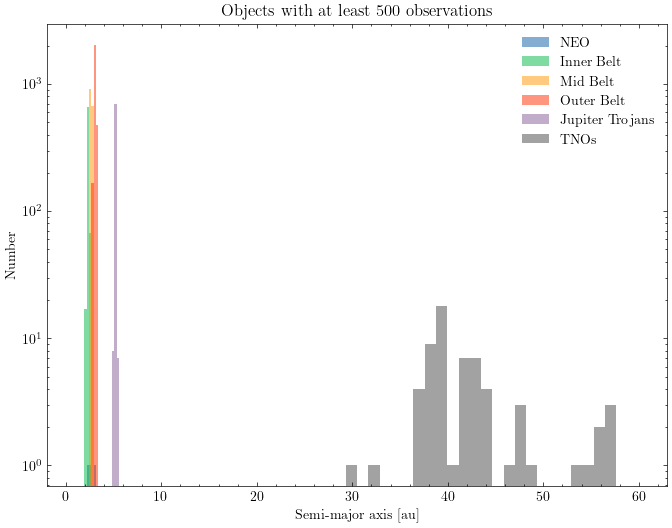

In [7]:
plt.figure(figsize=(8,6))

h = plt.hist(a[neo], bins=25, range=(1, 7),
             label='NEO', alpha=.5)

h = plt.hist(a[inner_belt], bins=25, range=(1, 7),
             label='Inner Belt', alpha=.5)

h = plt.hist(a[mid_belt], bins=25, range=(1, 7),
             label='Mid Belt', alpha=.5)
h = plt.hist(a[outer_belt], bins=25, range=(1, 7),
             label='Outer Belt', alpha=.5)

h = plt.hist(a[JT], bins=25, range=(1, 7),
             label='Jupiter Trojans', alpha=.5)
h = plt.hist(a[TNO], bins=50, range=(1, 60), label='TNOs', alpha=.5)

plt.xlabel('Semi-major axis [au]')
plt.ylabel('Number')
plt.yscale('log')
plt.legend()
plt.title("Objects with at least 500 observations")
plt.show()

Phase curves for body populations

In [8]:
stmt = """
SELECT
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magErr, dia.band, dia.midPointMjdTai,
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM
    dp03_catalogs_10yr.DiaSource as dia
INNER JOIN
    dp03_catalogs_10yr.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
WHERE
    dia.ssObjectId
    IN {}
ORDER by dia.ssObjectId
LIMIT 1000000
""".format(tuple(uniqueObj['ssObjectId'][all]))

indivObs = query(stmt).to_table()
# Add reduced magnitude column.
indivObs.add_column(reduced_magnitude(indivObs["mag"], indivObs['heliocentricDist'], indivObs['topocentricDist']), name='reducedMag')

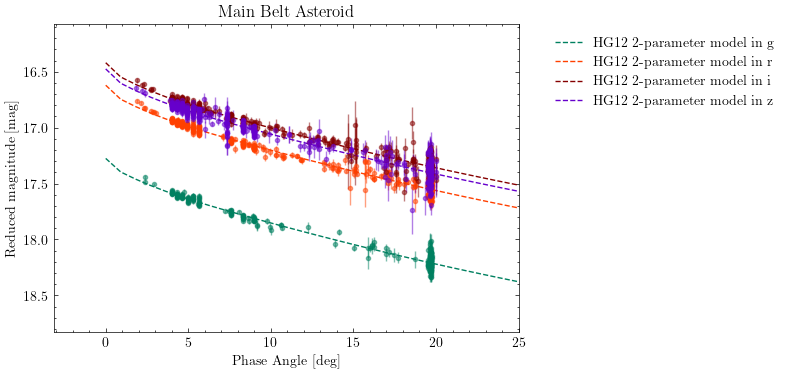

In [9]:
plt.figure(figsize=(6,4))
iObj = 1
sId = uniqueObj['ssObjectId'][main_belt_2k][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]
phases = np.linspace(0, 90, 100)

for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

    # Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                          [uniqueObj[ifilt+'_H'][main_belt_2k][iObj],
                           uniqueObj[ifilt+'_G12'][main_belt_2k][iObj]])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--',
             label='HG12 2-parameter model in %s' % ifilt)

plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title('Main Belt Asteroid')
plt.show()

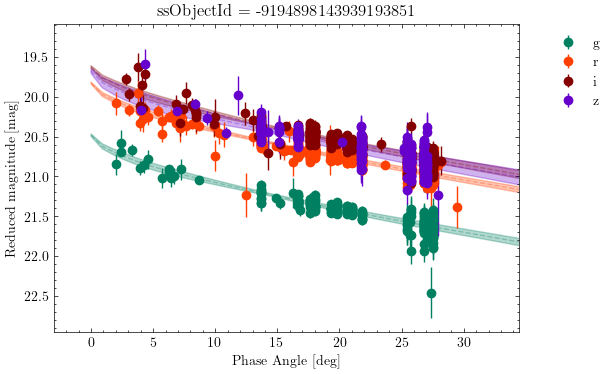

In [10]:
iObj = 3
sId = uniqueObj['ssObjectId'][main_belt_2k][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

plt.figure(figsize=(6,4))

for ifilt in filters:
    idx = tmp['band'] == ifilt
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='o',
                 color=filter_colors[ifilt], label=ifilt, zorder=10)

    HG12_mag_sso = HG12_model(np.deg2rad(phases),
                              [uniqueObj[ifilt+'_H'][main_belt_2k][iObj],
                               uniqueObj[ifilt+'_G12'][main_belt_2k][iObj]
                               ])
    plt.plot(phases, HG12_mag_sso, '--', alpha=0.3, color=filter_colors[ifilt])

    # Compute min/max values in reduced mag at each phase angle
    p1 = HG12_model(np.deg2rad(phases),
                    [uniqueObj[ifilt+'_H'][main_belt_2k][iObj]
                     + 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                     uniqueObj[ifilt+'_G12'][main_belt_2k][iObj]
                     + 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj]])

    p2 = HG12_model(np.deg2rad(phases),
                    [uniqueObj[ifilt+'_H'][main_belt_2k][iObj]
                     - 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                     uniqueObj[ifilt+'_G12'][main_belt_2k][iObj]
                     + 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj]])

    p3 = HG12_model(np.deg2rad(phases),
                    [uniqueObj[ifilt+'_H'][main_belt_2k][iObj]
                     + 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                     uniqueObj[ifilt+'_G12'][main_belt_2k][iObj]
                     - 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj]])

    p4 = HG12_model(np.deg2rad(phases),
                    [uniqueObj[ifilt+'_H'][main_belt_2k][iObj]
                     - 3*uniqueObj[ifilt+'_Herr'][main_belt_2k][iObj],
                     uniqueObj[ifilt+'_G12'][main_belt_2k][iObj]
                     - 3*uniqueObj[ifilt+'_G12err'][main_belt_2k][iObj]])

    HG_magHigh = np.maximum(np.maximum(p1, p2), np.maximum(p3, p4))
    HG_magLow = np.minimum(np.minimum(p1, p2), np.minimum(p3, p4))

    plt.fill_between(phases, HG_magLow, HG_magHigh, alpha=0.3, color=filter_colors[ifilt])

plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)
plt.show()

In [11]:
sId

-9194898143939193851

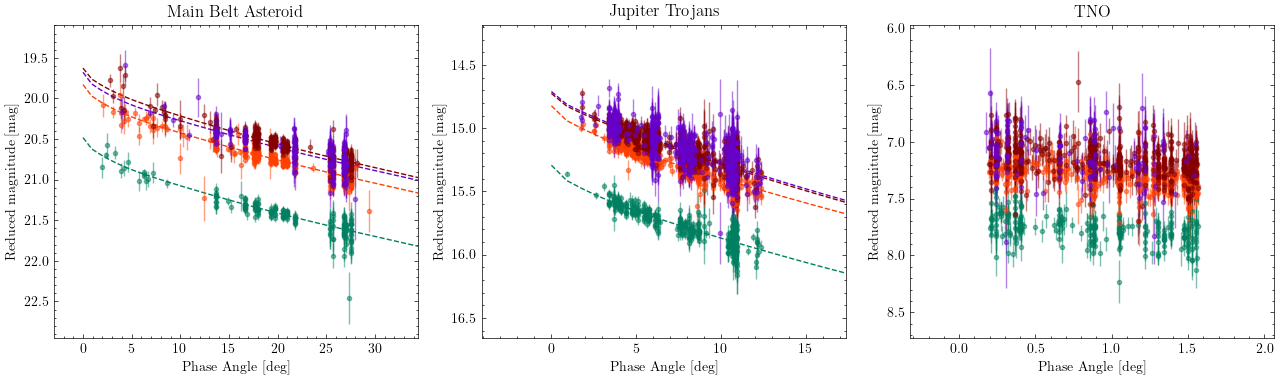

In [23]:
plt.figure(figsize=(13, 4))

plt.subplot(131)
for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

    # Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                          [uniqueObj[ifilt+'_H'][main_belt_2k][iObj],
                           uniqueObj[ifilt+'_G12'][main_belt_2k][iObj]])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--')


plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.title('Main Belt Asteroid')

plt.subplot(132)

iObj = 2
sId = uniqueObj['ssObjectId'][JT][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

    # Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                          [uniqueObj[ifilt+'_H'][JT_2k][iObj],
                           uniqueObj[ifilt+'_G12'][JT_2k][iObj]])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--')


plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.title('Jupiter Trojans')

plt.subplot(133)
iObj = 3
sId = uniqueObj['ssObjectId'][TNO][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5)

plt.xlim(tmp['phaseAngle'].min()-.5, tmp['phaseAngle'].max()+.5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.title('TNO')

plt.tight_layout()
plt.show()

5944 4821 712


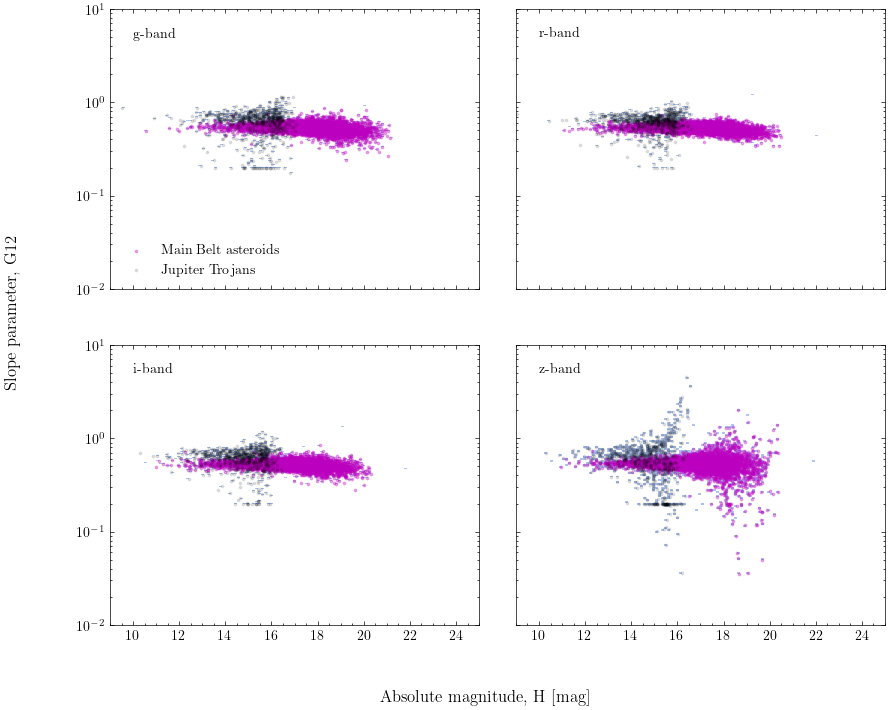

In [24]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, wspace=0.1, hspace=0.2)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()


for i, ifilt in enumerate(filters):
    sns.histplot(x=uniqueObj[ifilt+'_H'], y=uniqueObj[ifilt+'_G12'],
                 bins=100, log_scale=(False, True), ax=axs[i])
    axs[i].scatter(uniqueObj[ifilt+'_H'][main_belt],
                   uniqueObj[ifilt+'_G12'][main_belt],
                   s=3, c='m', alpha=0.3, label='Main Belt asteroids')
    axs[i].scatter(uniqueObj[ifilt+'_H'][JT],
                   uniqueObj[ifilt+'_G12'][JT],
                   s=3, c='k', alpha=0.1, label='Jupiter Trojans')
    axs[i].text(10, 5, ifilt+'-band')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)

axs[0].legend(loc=3, fontsize=10)
plt.xlim(9, 25)
plt.ylim(1e-2, 1e1)

fig.supxlabel('Absolute magnitude, H [mag]')
fig.supylabel('Slope parameter, G12')
print(len(uniqueObj), len(uniqueObj[main_belt_2k]),
      len(uniqueObj[JT_2k]))
plt.show()

/Users/br/Desktop/msc_project/.venv/lib/python3.11/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


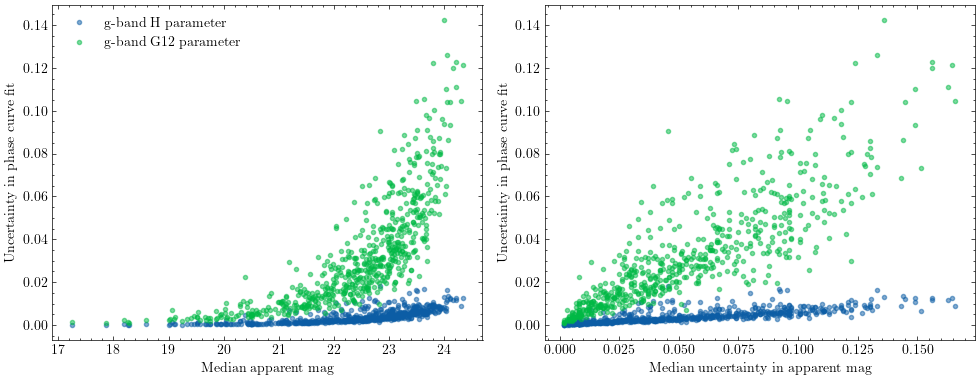

/Users/br/Desktop/msc_project/.venv/lib/python3.11/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


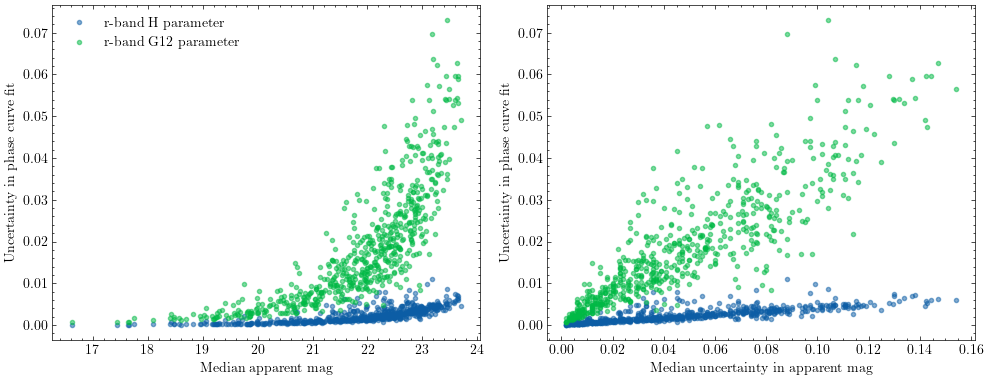

/Users/br/Desktop/msc_project/.venv/lib/python3.11/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


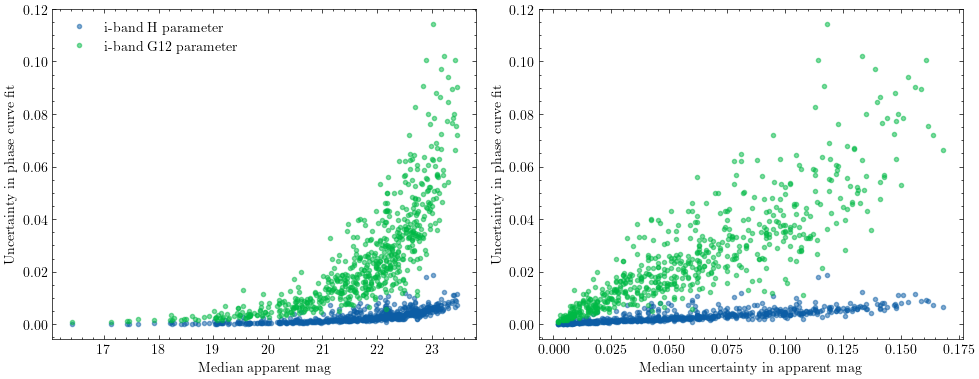

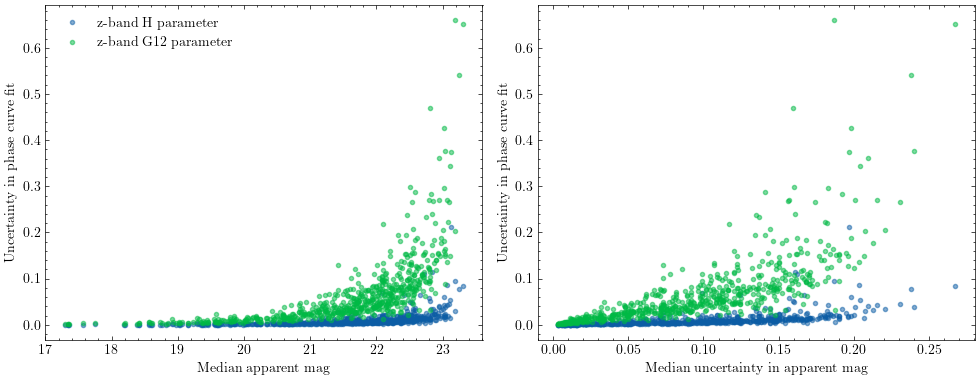

In [25]:
for filt in filters:
    mag_med = []
    magSigma_med = []

    for iobj in uniqueObj['ssObjectId'][main_belt]:
        idx = indivObs['ssObjectId'] == iobj
        tmp = indivObs[idx]
        idx_filt = tmp['band'] == filt

        mag_med.append(np.ma.median(tmp['mag'][idx_filt]))
        magSigma_med.append(np.ma.median(tmp['magErr'][idx_filt]))

    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.plot(mag_med, uniqueObj[filt+'_Herr'][main_belt], '.', alpha=.5,
            label=filt+'-band H parameter')
    plt.plot(mag_med, uniqueObj[filt+'_G12err'][main_belt], '.', alpha=.5,
            label=filt+'-band G12 parameter')
    plt.ylabel('Uncertainty in phase curve fit')
    plt.xlabel('Median apparent mag')
    plt.legend()

    plt.subplot(122)
    plt.plot(magSigma_med, uniqueObj[filt+'_Herr'][main_belt],
            '.', alpha=.5)
    plt.plot(magSigma_med, uniqueObj[filt+'_G12err'][main_belt],
            '.', alpha=.5)
    plt.ylabel('Uncertainty in phase curve fit')
    plt.xlabel('Median uncertainty in apparent mag')

    plt.tight_layout()
    plt.show()

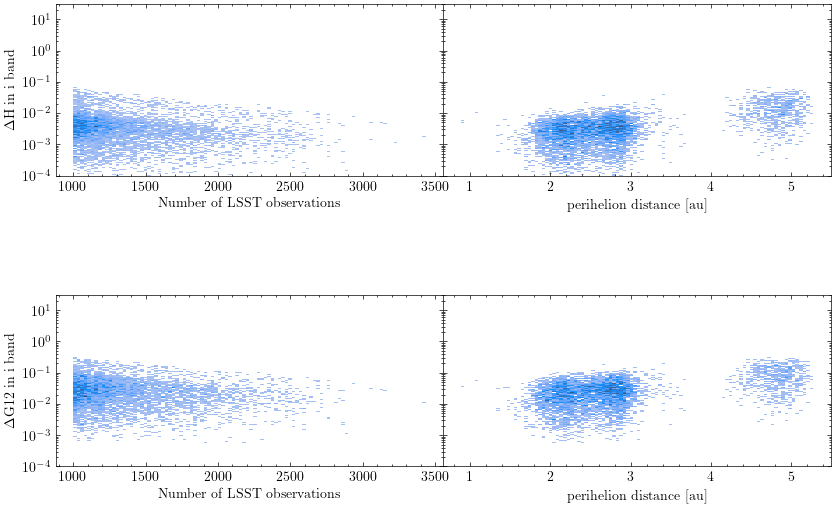

In [26]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0.7)
axs = gs.subplots(sharey=True)
ifilt = 'i'

sns.histplot(x=uniqueObj['numObs'], y=uniqueObj[ifilt+'_Herr'], bins=100,
             log_scale=(False, True), ax=axs[0, 0])
axs[0, 0].set_xlabel('Number of LSST observations')
axs[0, 0].set_ylabel(r'$\Delta$H in %s band' % ifilt)
plt.ylim(1e-4, 3e1)

sns.histplot(x=uniqueObj['q'], y=uniqueObj[ifilt+'_Herr'],
             bins=100, ax=axs[0, 1])
axs[0, 1].set_xlabel('perihelion distance [au]')

sns.histplot(x=uniqueObj['numObs'], y=uniqueObj[ifilt+'_G12err'],
             bins=100, log_scale=(False, True), ax=axs[1, 0])
axs[1, 0].set_xlabel('Number of LSST observations')
axs[1, 0].set_ylabel(r'$\Delta$G12 in %s band' % ifilt)

sns.histplot(x=uniqueObj['q'], y=uniqueObj[ifilt+'_G12err'],
             bins=100, ax=axs[1, 1])
axs[1, 1].set_xlabel('perihelion distance [au]')
plt.show()

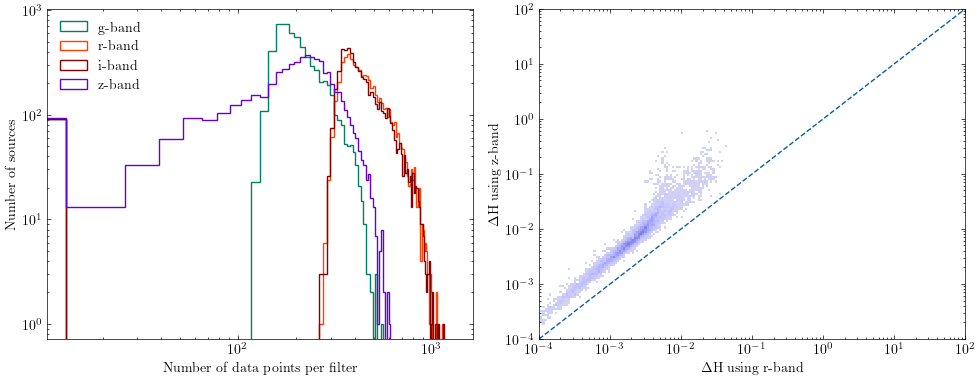

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i, ifilt in enumerate(filters):
    axs[0].hist(uniqueObj[ifilt+'_Ndata'], bins=100, range=(0, 1300),
                histtype='step', color=filter_colors[ifilt], label=ifilt+'-band')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('Number of data points per filter')
axs[0].set_ylabel('Number of sources')

sns.histplot(x=uniqueObj['r_Herr'], y=uniqueObj['z_Herr'],
             bins=100, log_scale=(True, True), color='b', ax=axs[1], alpha=0.7)

one2one = np.arange(1e-4, 1000, .1)
axs[1].plot(one2one, one2one, '--')
axs[1].set_ylim(1e-4, 1e2)
axs[1].set_xlim(1e-4, 1e2)
axs[1].set_ylabel(r'$\Delta$H using z-band')
axs[1].set_xlabel(r'$\Delta$H using r-band')

plt.tight_layout()
plt.show()